In [5]:
import numpy as np
import cv2
import math
import PIL
from PIL import ImageFont, Image, ImageDraw
from skimage import data
from skimage import io
from skimage import color
from skimage import filters
from skimage import exposure
from skimage import feature
from skimage import restoration
from skimage import img_as_ubyte
from skimage import measure
from matplotlib import cm
from skimage import morphology as m
from matplotlib import pyplot as plt
from scipy import ndimage as ndi
from skimage.transform import (hough_line, hough_line_peaks, probabilistic_hough_line)
%matplotlib inline

In [6]:
def showim(image, cm=None): #Show image
    fig = plt.figure(figsize = (13,13))
    ax = fig.add_subplot(111)
    ax.imshow(image, cmap=cm)    

In [35]:
def draw_text(im4t, coords, text):
    font = ImageFont.truetype("/usr/share/fonts/truetype/freefont/FreeSansBold.ttf",size=20)
    draw = ImageDraw.Draw(im4t)
    draw.text(coords, text,(255,255,0), font=font)
    draw = ImageDraw.Draw(im4t)

In [60]:
def create_mask(img, flag = False):#Create mask for edge detection 
                                #True - complex background, False - simple background
    img_hsv = color.rgb2hsv(img)
    if (flag):
        mask1 = (img_hsv[:,:,0]>0.3) & (img_hsv[:,:,0]<0.7)
        mask1 = m.remove_small_holes(mask1)
        mask1 = m.remove_small_objects(mask1)
        #mask1 = m.erosion(mask1)
        showim(mask1)
        #mask1 = m.dilation(mask1)
        #showim(mask1)
        mask2 = ~(img_hsv[:,:,0]<0.2)
        mask2 = m.remove_small_holes(mask2)
        showim(mask2)
        mask3= (img_hsv[:,:,1]>0.1)
        mask3 = m.remove_small_holes(mask3)
        mask4=mask1&mask2&mask3
    else:
        mask = (img_hsv[:,:,1]>0.3)&(img_hsv[:,:,0]>0.3)
        mask4=m.remove_small_holes(mask,min_size=50)
    showim(mask4, 'gray')
    return mask4

In [58]:
def count_cards(img_path, flag):#Count cards by detecting figures
    img = io.imread(img_path)
    img_gray = color.rgb2gray(img)
    #creatig mask for edge detection
    mask = create_mask(img, flag)
    new=img_gray*mask
    #Canny's edge detection
    edges = feature.canny(img_gray, sigma=1.7, mask=mask)
    #adjusting image: refining edges, erasing small edges/objects, filling small contours to remove them
    edges2 = m.dilation(edges)
    edges3 = m.remove_small_objects(edges2,150)
    filled = ndi.binary_fill_holes(edges3)
    newfin = m.remove_small_objects(filled, 300)
    #erode objects to get sharpen edges
    newfin= m.erosion(newfin,m.square(6))
    #once again erasing small objects
    newfin = m.remove_small_objects(newfin, 300)
    #label areas and count them
    labelled, num = measure.label(newfin, return_num=True)
    showim(img)
    showim(labelled)
    im4t = Image.open(img_path)
    for l in np.unique(labelled):
        if(l>0):
            i, j = np.where(labelled == l)
            draw_text(im4t, (j[0],i[0]), "№"+str(l))
        
    im4t.save("marked_image1.jpg")
    return num, newfin

In [44]:
#classify objects and mark them accordingly:
#P - if a polygon, n - number of vertices, C - if polygon is convex
def mark_cards(img, img_path):
    #transferring to OpenCV format
    cv_im = img_as_ubyte(img)
    #open image for drawing text
    im4t = Image.open(img_path)
    #finding contours
    ret,thresh = cv2.threshold(cv_im,0,255,0)
    im2, contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    for c in contours:
        res = "" #resulting string variable
        # approximate the contour
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.017 * peri, True)
        corners = len(approx)
        
        #delete point if it is too close to the previous (if there are less than 10 vertices)
        #we are not deleting the point itself from an array since it doesn't make much of a difference
        #we are just decreasing the "corners" counter
        for i, point in enumerate(approx):
            if i > 0:
                prev_i = i - 1
            else:
                prev_i = len(approx)-1
                
            previous = approx[prev_i]
            y1 = point.item(1) - previous.item(1)
            x1 = point.item(0) - previous.item(0)
            if ((corners<10) & (math.sqrt(x1**2 + y1**2)<12)):
                corners = corners-1
        #calcuating some contour properties for classification
        perimeter = cv2.arcLength(c,True)
        area = cv2.contourArea(c)
        x,y,w,h = cv2.boundingRect(c)
        aspect_ratio = float(w)/h
        hull = cv2.convexHull(c)
        hull_area = cv2.contourArea(hull)
        solidity = float(area)/hull_area
        areaCORN =  cv2.contourArea(approx)
        #all our non-polygons tend to have >=7 vertices, so if there are less than 7 verticies it is a polygon
        if (corners<7):
            res = "P"+res+ str(corners)
        else:
            #most of our non-polygons can be detected by the difference between their initial contour area and 
            #and area of a polygon, built on approximated vertices
            if ((area-areaCORN < 168)):
                res = "P"+res+ str(corners)
        #checking for convexity
        if(solidity>0.94):
            if(res!=""):
                res=res+"C"
        else:
            #However it is hard to distinguish non-convex polygon with 8 verticies and non-convex non-polygon
            #whose contour was approximated with 8 vertices.
            #In our case the ratio of width to height of bounding rect of the object helps to destinguish between these two.
            if (corners==8)&(aspect_ratio>0.9):
                res=""
        draw_text(im4t, (approx[0].item(0)-18, approx[0].item(1)),res)
        draw = ImageDraw.Draw(im4t)
    im4t.save("marked_image2.jpg")
    return 

21


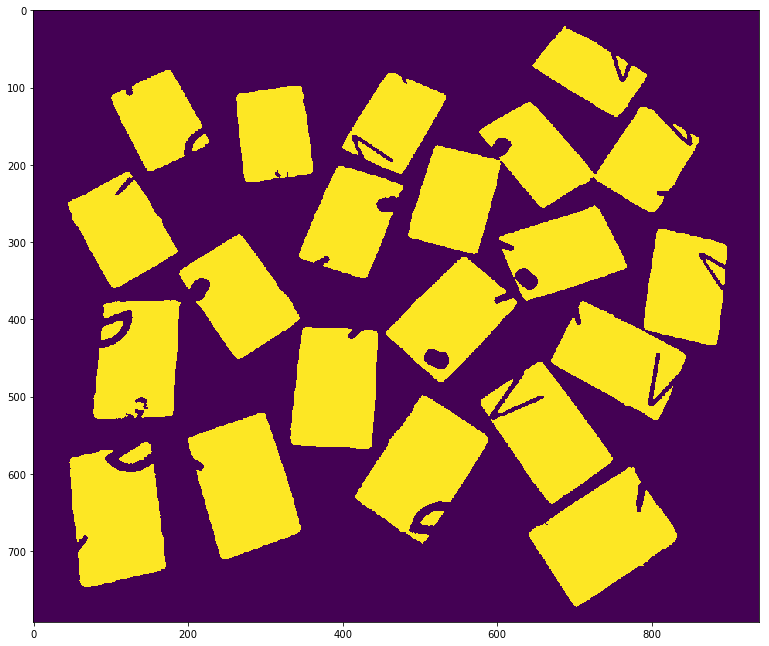

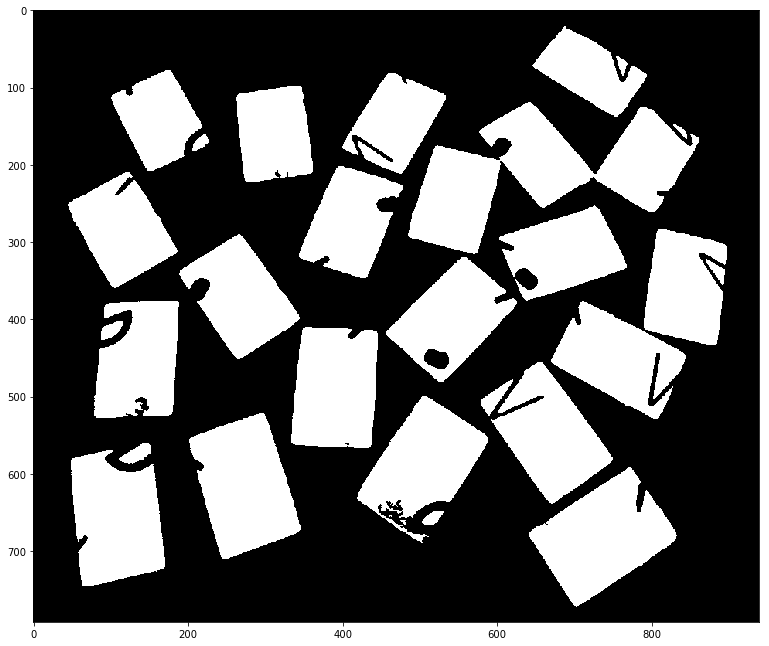

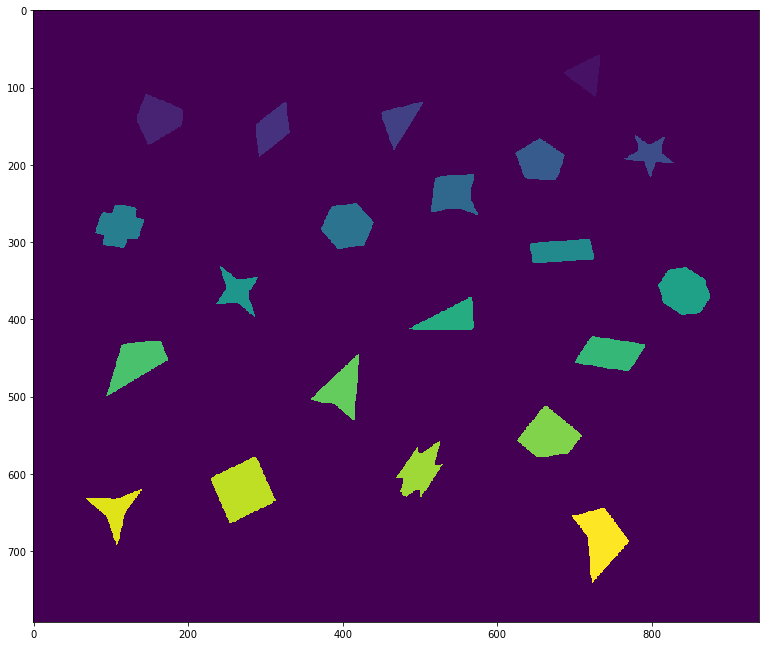

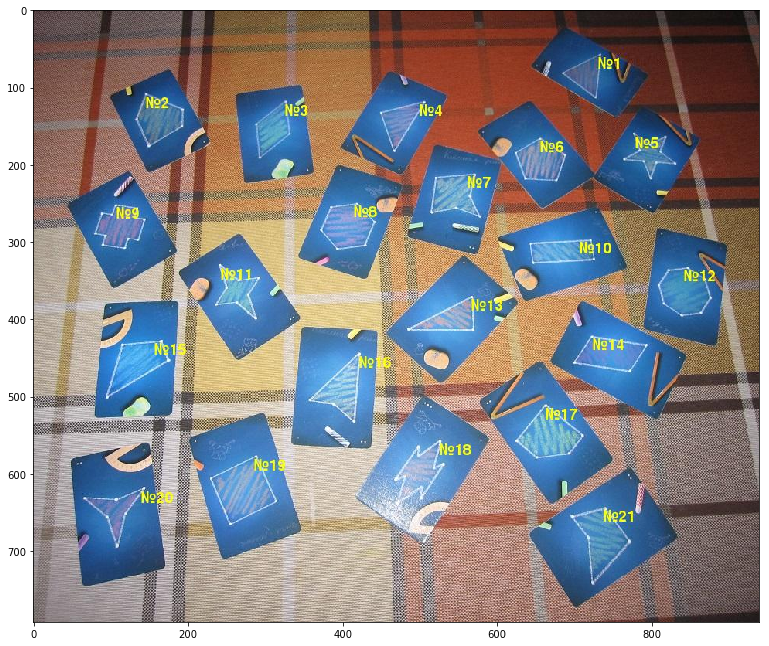

In [61]:
img_path = "./Obraztsy/IMG_9.jpg"
num, img = count_cards(img_path, True)
mark_cards(img, img_path)
print(num)
showim(cv2.cvtColor(cv2.imread("marked_image1.jpg"), cv2.COLOR_BGR2RGB))
showim(cv2.cvtColor(cv2.imread("marked_image2.jpg"), cv2.COLOR_BGR2RGB))